In [1]:
from pyspark.sql import SparkSession
# start spark session configured for spark nlp
spark = SparkSession.builder \
     .master('local[*]') \
     .appName('Spark NLPm') \
     .config('spark.jars.packages', 
             'com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.3') \
     .config("spark.executor.memory", "20g")\
     .config("spark.driver.memory", "20g")\
     .config("spark.memory.offHeap.enabled","true")\
     .config("spark.memory.offHeap.size","16g")\
     .getOrCreate()

22/06/04 08:14:16 WARN Utils: Your hostname, MacBook-Pro-cua-Pham.local resolves to a loopback address: 127.0.0.1; using 172.30.1.30 instead (on interface en0)
22/06/04 08:14:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hienpham/.ivy2/cache
The jars for the packages stored in: /Users/hienpham/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ff27cc10-6798-40bb-9e0d-0439da3fee29;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.3 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombo

In [2]:
spark.catalog.clearCache()

In [3]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (RegexTokenizer, Normalizer, SentenceDetector,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
from wordcloud import STOPWORDS

documentAssembler = DocumentAssembler() \
     .setInputCol('reviewText') \
     .setOutputCol('document')

sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = RegexTokenizer() \
     .setInputCols(['sentence']) \
     .setOutputCol('token') \
     .setPattern("[^\w']")

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemma']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(list(STOPWORDS))

finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           sentenceDetector,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]


22/06/04 08:14:43 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [4]:
df = spark.read.option("header", True).csv('kindle_reviews.csv')
df = df.drop("_c0")
df = df.dropna()

In [5]:
from pyspark.sql.functions import col, lit, split, regexp_replace, when
from pyspark.sql.types import IntegerType

df1 = df.withColumn('helpful_votes', split(regexp_replace(col("helpful"), "[\[\]]", ""), ",").getItem(0))\
.withColumn('total_votes', split(regexp_replace(col("helpful"), "[\[\]]", ""), ",").getItem(1))


from pyspark.sql.types import IntegerType 
df_greaterthanten = df1.withColumn("helpful_votes",col("helpful_votes").cast(IntegerType()))\
.withColumn("total_votes",col("total_votes").cast(IntegerType()))\
.withColumn("overall",col("overall").cast(IntegerType()))\
.where(col("total_votes") >= 10)

In [6]:
df_greaterthanten.count()

21383

In [7]:
threshold = 0.5
from pyspark.sql.functions import udf

def func(helpful_votes, total_votes):
    if helpful_votes/total_votes >= threshold:
        return 1
    return 0
func_udf = udf(func, IntegerType())

df_is_helpful = df_greaterthanten.withColumn('is_helpful', func_udf(col('helpful_votes'), col('total_votes')))

In [32]:
df_is_helpful.count()

451067

In [8]:
data = df_is_helpful.select('reviewText')
equifax = pipeline.fit(data).transform(data)

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number
w = Window.orderBy(monotonically_increasing_id())

finished_clean_lemma = equifax.select('finished_clean_lemma').withColumn("index", row_number().over(w))
df_is_helpful = df_is_helpful.withColumn("index", row_number().over(w))

df_features = finished_clean_lemma.join(df_is_helpful, finished_clean_lemma.index == df_is_helpful.index, 'inner')

In [35]:
df_features.count()

22/06/03 22:50:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 22:50:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


451067

In [10]:
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, IDF, HashingTF

df_light = df_features.select("overall", "finished_clean_lemma", "is_helpful", "reviewerID")
def build_ngrams(inputCol="finished_clean_lemma", n=3):

#     ngrams = [
#         NGram(n=n, inputCol="finished_clean_lemma", outputCol="3_grams")
#     ]

#     vectorizers = [
#         CountVectorizer(inputCol="3_grams", outputCol="3_counts")
#     ]
    htf = [HashingTF(numFeatures=5000, inputCol="finished_clean_lemma", outputCol="tf")]
    
    idf = [
        IDF(inputCol="tf", outputCol="3_tfidf")
    ]
    
#     assembler = [VectorAssembler(
#         inputCols=["overall", "3_tfidf"],
#         outputCol="features"
#     )]

    return Pipeline(stages= htf + idf)

df_ngrams = build_ngrams().fit(df_light).transform(df_light)

22/06/04 09:42:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:42:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [37]:
df_ngrams.count()

22/06/03 23:01:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 23:01:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


451067

In [11]:
from pyspark.sql.types import DoubleType
sum_ = udf(lambda v: float(v.values.sum()), DoubleType())
df_ngrams = df_ngrams.withColumn("idf_sum", sum_("3_tfidf"))

In [12]:
from pyspark.ml.feature import VectorAssembler
cols = ["idf_sum", "overall"]
assembler = VectorAssembler()\
  .setInputCols(cols)\
  .setOutputCol("features")
featureDf = assembler.transform(df_ngrams)
featureDf = featureDf.select("*").where(col("idf_sum") > 0)
# featureDf.printSchema()

In [41]:
featureDf.count()

22/06/03 23:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 23:02:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


451052

In [13]:
featureDf.filter(col("overall") == 0.0).show(1)

22/06/04 09:46:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:46:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+--------------------+----------+----------+---+-------+-------+--------+
|overall|finished_clean_lemma|is_helpful|reviewerID| tf|3_tfidf|idf_sum|features|
+-------+--------------------+----------+----------+---+-------+-------+--------+
+-------+--------------------+----------+----------+---+-------+-------+--------+



In [14]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
  .setInputCol("is_helpful")\
  .setOutputCol("label")
labelDf = indexer.fit(featureDf).transform(featureDf)
# labelDf.printSchema()

22/06/04 09:46:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:46:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [67]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when

def calculateWeights (d: DoubleType, balancingRatio: DoubleType):
      if d == 1.0:
        return 1 * balancingRatio
      else:
        return (1 * (1.0 - balancingRatio))


    
def balanceDataset(dataset): 
    numNegatives = dataset.filter(col("label") == 1).count()
    datasetSize = dataset.count()
    balancingRatio = (float(datasetSize - numNegatives)) / datasetSize
#     udf_func = udf(lambda x, y: calculateWeights(x, y), returnType=DoubleType())
#     weightedDataset = dataset.withColumn("classWeightCol", udf_func(dataset.label, lit(balancingRatio)))
    weightedDataset = dataset.withColumn("classWeightCol", \
                    when(col("label") == 1.0, balancingRatio).otherwise(1.0 - balancingRatio))
    return weightedDataset

balancedDf = balanceDataset(labelDf)

22/06/03 15:47:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 15:47:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 15:48:08 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/06/03 15:48:11 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/06/03 15:48:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 15:48:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 15:49:02 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/06/03 15:49:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 

In [15]:
major_df = labelDf.where(col("is_helpful") == 1.0)
minor_df = labelDf.where(col("is_helpful") == 0.0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))



22/06/04 09:54:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:54:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


ratio: 11


In [16]:
from pyspark.sql.functions import explode, array

a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
combined_df = major_df.unionAll(oversampled_df)

In [45]:
combined_df.count()

22/06/03 23:58:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 23:58:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 23:58:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 23:58:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


785708

In [99]:
labelDf.count()

22/06/03 16:48:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 16:48:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 16:48:47 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/06/03 16:48:50 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


21108

In [17]:
training, testing = combined_df.randomSplit([0.7, 0.3], seed = 1)

In [18]:
from pyspark.ml.classification import LogisticRegression

# lr = LogisticRegression(maxIter=200, regParam=0.01, elasticNetParam=0.8, weightCol="classWeightCol", family="multinomial")
lr = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=0.8)
lrModel = lr.fit(training)
# print("Coefficients: " + str(lrModel.coefficients))
# print("Intercept: " + str(lrModel.intercept))

22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:56:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 0

In [19]:
predictionDf = lrModel.transform(testing)
# predictionDf.select('overall','idf_sum', 'label','rawPrediction','probability','prediction')\
# .where(col('is_helpful') > 0).show(20)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
  .setLabelCol("label")\
  .setRawPredictionCol("prediction")\
  .setMetricName("areaUnderROC")

accuracy = evaluator.evaluate(predictionDf)
print(accuracy)

22/06/04 09:58:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:58:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:58:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 09:58:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.7913627229006017


In [21]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(maxDepth=2)
dtModel = dt.fit(training)

22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:01:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

In [22]:
predictionDt = dtModel.transform(testing)
accuracy = evaluator.evaluate(predictionDt)
print(accuracy)

22/06/04 10:09:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:09:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:09:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:09:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.7781347697315285


In [23]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=5, maxDepth=5, seed=42)
rfModel = rf.fit(training)

22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

In [24]:
predictionRf = rfModel.transform(testing)
accuracy = evaluator.evaluate(predictionRf)
print(accuracy)

22/06/04 10:10:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:10:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.7946733690663492


In [26]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="gaussian")
nbModel = nb.fit(training)

22/06/04 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

In [27]:
predictionNb = nbModel.transform(testing)
accuracy = evaluator.evaluate(predictionNb)
print(accuracy)

22/06/04 10:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:12:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.78428491558556


22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:13:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:17:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

22/06/04 10:22:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:22:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:22:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:22:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:22:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:22:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

22/06/04 10:28:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:28:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:28:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:28:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:28:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:28:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

22/06/04 10:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:36:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:36:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:36:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 1

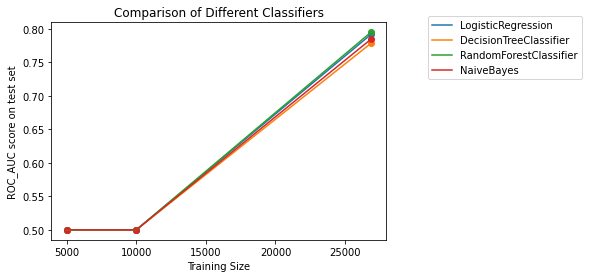

<Figure size 1440x1008 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

def getAccuracy(method, trainingSet, testingSet):
    model = method.fit(trainingSet)
    prediction = model.transform(testingSet)
    accuracy = evaluator.evaluate(prediction)
    return accuracy

train_feature_list = [training.limit(5000), training.limit(10000), training]
clf_list = [lr, dt, rf, nb]

FIG_SIZE = (20,14)
# Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a in train_feature_list:
        y_graph.append(getAccuracy(clf, a, testing))
        x_graph.append(a.count())
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show() 